## Soru 6

**Soru:** Fraud case'i üzerinde train&test&validation split, encoding, scaling,modelleme çalışmaları Python'da yapılarak, modelin görmediği dataset üzerinde başarılı sonuç alacak bir model örneği yapılmalı.

In [1]:
# Kütüphane yüklemeleri ve derste yapılan temel ön işlemleri kopyalayarak başlıyorum
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import random

In [2]:
df = pd.read_csv('auto_insurance_csv.csv')
df = df.drop(['_c39','Unnamed: 0'], axis = 1)
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df['policy_csl'] = df.policy_csl.fillna("MISSING")
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)
df['umbrella_limit'] = df.umbrella_limit.astype(str)
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
  if (umb != '0.0') & (umb != '9999'):
    df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')
    
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['age'] = df.age.fillna(9999)
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)
required_columns = ['incident_date','policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','auto_make',
       'auto_model', 'auto_year', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group', 'fraud_reported']
df1 = df[required_columns]

<ipython-input-2-c0d31427e599>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')


In [3]:
# bu kolon her satırda farklı bir kategorik değişken oluşturduğu için işimize yaramaz
df1["incident_location"].nunique()

1000

In [4]:
# bu kolon identifier gibi bir şey olduğu için pek işimize yaramaz
df1["insured_zip"].nunique()

995

In [5]:
# yukarda bahsettiğim 2 kolonu dropladım
df1 = df1.drop(["incident_location", "insured_zip"], axis = 1)

In [6]:
df1.head()

,incident_date,policy_state,policy_csl,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make,auto_model,auto_year,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group,fraud_reported
0,2015-01-25,OH,250/500,0.0,MALE,MD,craft-repair,other,husband,53300,...,Saab,92x,2004,100,False,46-50,301-350,medium,501-1000,1
1,2015-01-21,IN,250/500,other,MALE,MD,machine-op-inspct,other,other-relative,0,...,Mercedes,E400,2007,3130,False,41-45,201-250,medium,1501-2000,1
2,2015-02-22,OH,MISSING,other,FEMALE,PhD,sales,other,own-child,35100,...,Dodge,RAM,2007,5282,False,26-30,101-150,medium,1501-2000,0
3,2015-01-10,IL,MISSING,other,FEMALE,PhD,armed-forces,other,unmarried,48900,...,Chevrolet,Tahoe,2014,8996,False,41-45,251-300,medium,1501-2000,1
4,2015-02-17,IL,MISSING,other,MALE,Associate,sales,other,unmarried,66000,...,Accura,RSX,2009,256,False,41-45,201-250,high,501-1000,0


In [7]:
# gruplama yaparak oluşturduğumuz kolonları object tipine çevirdim
new_cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in new_cat_cols:
  df1[col] = df1[col].astype('object')

In [8]:
# %87 boş değer içerdiği için silmeye karar verdim 
df1["policy_csl"].value_counts()

MISSING     873
100/300      44
250/500      43
500/1000     40
Name: policy_csl, dtype: int64

In [9]:
df1 = df1.drop(["policy_csl"],axis=1)

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   incident_date                 1000 non-null   datetime64[ns]
 1   policy_state                  1000 non-null   object        
 2   umbrella_limit                1000 non-null   object        
 3   insured_sex                   1000 non-null   object        
 4   insured_education_level       1000 non-null   object        
 5   insured_occupation            1000 non-null   object        
 6   insured_hobbies               1000 non-null   object        
 7   insured_relationship          1000 non-null   object        
 8   capital-gains                 1000 non-null   int64         
 9   capital-loss                  1000 non-null   int64         
 10  incident_type                 1000 non-null   object        
 11  collision_type                1

In [11]:
# kategorik kolonları bir arada görmek istedim
cat_cols = []
for col in df1.columns:
  if df1[col].dtype == 'object':
    cat_cols.append(col)

cat_cols

['policy_state',
 'umbrella_limit',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'insured_relationship',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'property_damage',
 'police_report_available',
 'auto_make',
 'auto_model',
 'location_check',
 'age_group',
 'months_as_customer_groups',
 'policy_annual_premium_groups',
 'policy_deductable_group']

In [12]:
# buradan tüm kolonlara bakıp hangisine OneHotEncoder hangisine OrdinalEncoder uygulayacağıma karar vereceğim
# ordinal kolonları OrdinalEncoder'a, nominal kolonları OneHotEncoder'a sokacağım
pd.set_option("display.max_columns", None)
df1[cat_cols].head()

,policy_state,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,property_damage,police_report_available,auto_make,auto_model,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
0,OH,0.0,MALE,MD,craft-repair,other,husband,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,YES,YES,Saab,92x,False,46-50,301-350,medium,501-1000
1,IN,other,MALE,MD,machine-op-inspct,other,other-relative,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,?,?,Mercedes,E400,False,41-45,201-250,medium,1501-2000
2,OH,other,FEMALE,PhD,sales,other,own-child,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,NO,MISSING,Dodge,RAM,False,26-30,101-150,medium,1501-2000
3,IL,other,FEMALE,PhD,armed-forces,other,unmarried,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,?,NO,Chevrolet,Tahoe,False,41-45,251-300,medium,1501-2000
4,IL,other,MALE,Associate,sales,other,unmarried,Vehicle Theft,?,Minor Damage,None,NY,Arlington,NO,MISSING,Accura,RSX,False,41-45,201-250,high,501-1000


In [13]:
pd.reset_option("display.max_columns")

In [14]:
# ordinal_list'e OrdinalEncoder, ohe_list'e OneHotEncoder uygulayacağım
# incident_date silineceği için onu dikkate almadım
ordinal_list = ["insured_education_level", "incident_severity", "age_group", "months_as_customer_groups", 
                "policy_annual_premium_groups", "policy_deductable_group"]

ohe_list = ["insured_sex", "policy_state", "umbrella_limit", "insured_occupation", "insured_hobbies", 
            "insured_relationship", "incident_type", "collision_type", "authorities_contacted", 
            "incident_state", "incident_city", "property_damage", "police_report_available", "auto_make", 
            "auto_model", "location_check"]

In [15]:
# sıralayacağımız değerleri görmek için unique metodunu kullanıyorum
df1["insured_education_level"].unique()

array(['MD', 'PhD', 'Associate', 'Masters', 'High School', 'College',
       'JD'], dtype=object)

In [16]:
# birden fazla doktora derecesi olmasının bize faydası olacağını düşünmediğimden hepsini birleştirdim
df1['insured_education_level'] = df1['insured_education_level'].str.replace('MD', 'Doctors Degree')
df1['insured_education_level'] = df1['insured_education_level'].str.replace('PhD', 'Doctors Degree')
df1['insured_education_level'] = df1['insured_education_level'].str.replace('JD', 'Doctors Degree')
df1["insured_education_level"].unique()

array(['Doctors Degree', 'Associate', 'Masters', 'High School', 'College'],
      dtype=object)

In [17]:
df1["incident_severity"].unique()

array(['Major Damage', 'Minor Damage', 'Total Loss', 'Trivial Damage'],
      dtype=object)

In [18]:
df1["age_group"].unique()

array(['46-50', '41-45', '26-30', '36-40', '31-35', '61-65', '9999',
       '56-60', '51-55', '21-25', '15-20'], dtype=object)

In [19]:
df1["months_as_customer_groups"].unique()

array(['301-350', '201-250', '101-150', '251-300', '151-200', '0-50',
       '451-500', '51-100', '351-400', '401-450'], dtype=object)

In [20]:
df1["policy_annual_premium_groups"].unique()

array(['medium', 'high', 'low', 'very high', 'very low'], dtype=object)

In [21]:
df1["policy_deductable_group"].unique()

array(['501-1000', '1501-2000', '0-500'], dtype=object)

In [22]:
# ordinal sıralamaları bu şekilde listelere tanımlayacağım
educ = ["High School", "Associate", "College", "Masters", "Doctors Degree"]
sever = ["Trivial Damage", "Minor Damage", "Major Damage", "Total Loss"]
age = ['9999', "15-20", "21-25", '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65']
months = ['0-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350', '351-400', '401-450', '451-500']
premium = ["very low","low","medium","high","very high"]
deduct = ['0-500', '501-1000', '1501-2000']

In [23]:
# df1 verisetinden validation ve model bölme, yeni tarihli satırları validation yaptık
df1_val = df1.sort_values(by='incident_date',ascending=False).head(200)
df1_model = df1.sort_values(by='incident_date',ascending=False).tail(800)

In [24]:
# sıralamayı yaptıktan sonra incident_date droplandı
df1_val = df1_val.drop(["incident_date"],axis=1)
df1_model = df1_model.drop(["incident_date"],axis=1)

In [25]:
df1 = df1.drop(["incident_date"],axis=1)

## Encoding

In [26]:
# önce ordinal encoder'i belirttiğim kolonlara uyguluyorum
from sklearn.preprocessing import OrdinalEncoder

df2_model = df1_model
oe = OrdinalEncoder(categories=[educ,sever,age,months,premium,deduct], dtype = "int64")
df2_model[ordinal_list] = oe.fit_transform(df2_model[ordinal_list])
df2_model[ordinal_list].head()

,insured_education_level,incident_severity,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
511,4,0,7,5,2,1
894,4,1,4,0,2,0
125,4,3,5,4,2,1
895,0,2,5,3,2,0
485,1,3,3,1,2,2


In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# OneHotEncoder'i fit edip column transformer üzerinden modele uyguladım
ohe = OneHotEncoder(handle_unknown='ignore', dtype="int64")
ct = make_column_transformer((ohe, ohe_list), remainder="passthrough")
# yeni bir df oluşturarak transformu gerçekleştirdim ve kolon isimlerini get_feature_names yardımıyla verdim
df2_model = pd.DataFrame(ct.fit_transform(df2_model).toarray(), columns=ct.get_feature_names())

In [28]:
# modelin OneHotEncoding ve OrdinalEncoder uygulanmış hali
df2_model.head()

,onehotencoder__x0_FEMALE,onehotencoder__x0_MALE,onehotencoder__x1_IL,onehotencoder__x1_IN,onehotencoder__x1_OH,onehotencoder__x2_0.0,onehotencoder__x2_9999,onehotencoder__x2_other,onehotencoder__x3_adm-clerical,onehotencoder__x3_armed-forces,...,bodily_injuries,witnesses,total_claim_amount,auto_year,claim_day_of_policy,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group,fraud_reported
0,1,0,0,0,1,1,0,0,0,0,...,2,3,6560,2003,4427,7,5,2,1,0
1,0,1,0,1,0,1,0,0,0,0,...,1,3,6000,2000,8921,4,0,2,0,0
2,0,1,0,1,0,0,0,1,0,0,...,2,3,36300,2013,205,5,4,2,1,0
3,0,1,1,0,0,1,0,0,0,1,...,0,3,55200,1998,1980,5,3,2,0,1
4,0,1,0,1,0,1,0,0,1,0,...,2,1,48290,1995,7692,3,1,2,2,0


## Features and Target

In [29]:
# verisetini feature ve target olarak ayırıyorum
X = df2_model.loc[:, df2_model.columns != 'fraud_reported']
y = df2_model["fraud_reported"]

## Scaling

In [30]:
# Feature değerleri StandardScaler'a sokuyorum
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [31]:
X

array([[ 0.93228691, -0.93228691, -0.73178456, ...,  0.51401352,
        -0.01310669,  0.02944272],
       [-1.07263117,  1.07263117, -0.73178456, ..., -1.57335104,
        -0.01310669, -1.21025068],
       [-1.07263117,  1.07263117, -0.73178456, ...,  0.09654061,
        -0.01310669,  0.02944272],
       ...,
       [-1.07263117,  1.07263117,  1.36652242, ...,  1.76643226,
        -1.76066488,  1.26913612],
       [-1.07263117,  1.07263117, -0.73178456, ..., -0.73840521,
         1.73445151, -1.21025068],
       [ 0.93228691, -0.93228691, -0.73178456, ..., -1.57335104,
        -1.76066488, -1.21025068]])

## Splitting in train and test data

In [32]:
# Modelin train-test olarak ayrılması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

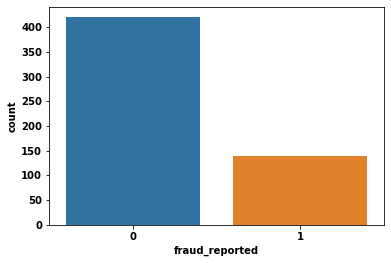

In [33]:
# train'in target değişkeninin ne kadarı 0 ne kadarı 1 kontrolü
# verisetinin imbalancelığı train'e de yansımış
chck = pd.DataFrame()
chck['fraud_reported'] = y_train

sns.countplot(chck['fraud_reported'])

# Logistic Regression

In [34]:
# ilk model denemesi, 1'leri tahmin etmesi düşük çıktığı için oversampling yapmaya karar verdik
lr = LogisticRegression()

lr.fit(X_train, y_train)
preds = lr.predict(X_test)

score = lr.score(X_test, y_test)
print(score)
print(classification_report(y_test, preds))

0.7125
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       170
           1       0.51      0.36      0.42        70

    accuracy                           0.71       240
   macro avg       0.64      0.61      0.61       240
weighted avg       0.69      0.71      0.70       240



## Synthetic Minority Over-sampling Technique (SMOTE)

In [35]:
oversample = SMOTE(random_state=9)

In [36]:
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

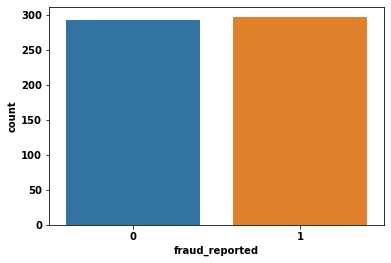

In [38]:
# oversampling yapıldı ve 0-1 dengelendi
chck2 = pd.DataFrame()
chck2['fraud_reported'] = y_train

sns.countplot(chck2['fraud_reported'])

0.6785714285714286

              precision    recall  f1-score   support

           0       0.68      0.69      0.68       128
           1       0.67      0.67      0.67       124

    accuracy                           0.68       252
   macro avg       0.68      0.68      0.68       252
weighted avg       0.68      0.68      0.68       252



<AxesSubplot:>

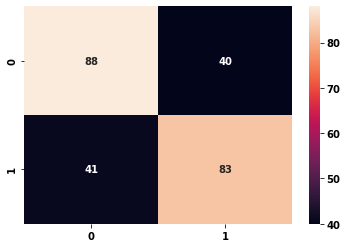

In [39]:
# oversampling sonrası 0 ve 1'in recall oranları birbirine yaklaştı
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
score = lr.score(X_test, y_test)
print(score)
print()
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

## Decision Tree

0.8571428571428571

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       128
           1       0.89      0.81      0.85       124

    accuracy                           0.86       252
   macro avg       0.86      0.86      0.86       252
weighted avg       0.86      0.86      0.86       252



<AxesSubplot:>

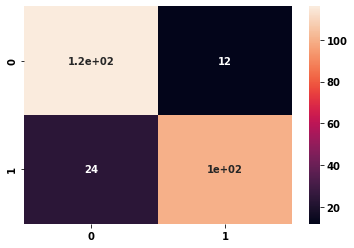

In [40]:
# diğer modeller deneniyor
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
preds = dtc.predict(X_test)

score = dtc.score(X_test, y_test)
print(score)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

**Gelişme var, diğerlerine bakmaya devam edelim**

## Random Forest

92.46031746031747

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       128
           1       0.96      0.89      0.92       124

    accuracy                           0.92       252
   macro avg       0.93      0.92      0.92       252
weighted avg       0.93      0.92      0.92       252



<AxesSubplot:>

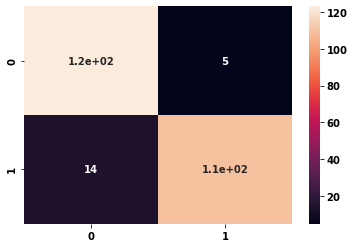

In [41]:
rfc = RandomForestClassifier(random_state = 1)

rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

**Çok daha iyi, bakmaya devam edelim**

## Support Vector

Score: 0.8849206349206349
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       128
           1       0.86      0.92      0.89       124

    accuracy                           0.88       252
   macro avg       0.89      0.89      0.88       252
weighted avg       0.89      0.88      0.88       252



<AxesSubplot:>

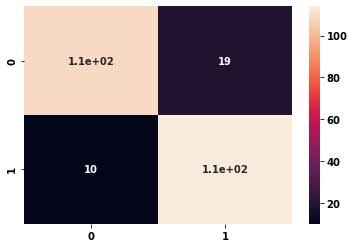

In [42]:
svc = SVC(kernel='poly', probability=True, random_state = 10)
svc.fit(X_train, y_train)

preds = svc.predict(X_test)

print('Score:' , svc.score(X_test, y_test))
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

**1'leri tahmin etmede iyi, ancak genel skoru rfc'den düşük**

Score: 0.8928571428571429
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       128
           1       0.88      0.90      0.89       124

    accuracy                           0.89       252
   macro avg       0.89      0.89      0.89       252
weighted avg       0.89      0.89      0.89       252



<AxesSubplot:>

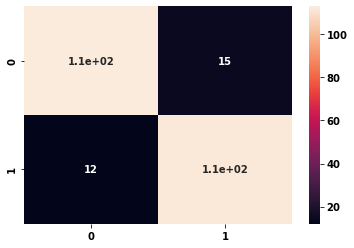

In [43]:
svc_rbf = SVC(kernel='rbf', probability=True, random_state = 10)
svc_rbf.fit(X_train, y_train)

preds = svc_rbf.predict(X_test)

print('Score:' , svc_rbf.score(X_test, y_test))
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

**1'leri tahmin etmede bu da nerdeyse rbf kerneli kadar iyi, 0'larda daha başarılı**

## CatBoost

In [75]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier()

cbc.fit(X_train, y_train)
preds = cbc.predict(X_test)

Learning rate set to 0.008212
0:	learn: 0.6852770	total: 25.7ms	remaining: 25.6s
1:	learn: 0.6777574	total: 27.9ms	remaining: 13.9s
2:	learn: 0.6701436	total: 30.1ms	remaining: 10s
3:	learn: 0.6623341	total: 32.5ms	remaining: 8.08s
4:	learn: 0.6551103	total: 34.8ms	remaining: 6.92s
5:	learn: 0.6475668	total: 37ms	remaining: 6.13s
6:	learn: 0.6409041	total: 39.3ms	remaining: 5.58s
7:	learn: 0.6350907	total: 41.7ms	remaining: 5.17s
8:	learn: 0.6292116	total: 44ms	remaining: 4.84s
9:	learn: 0.6229649	total: 46.3ms	remaining: 4.58s
10:	learn: 0.6163531	total: 48.5ms	remaining: 4.36s
11:	learn: 0.6108215	total: 50.8ms	remaining: 4.18s
12:	learn: 0.6041695	total: 53.1ms	remaining: 4.03s
13:	learn: 0.5982242	total: 55.4ms	remaining: 3.9s
14:	learn: 0.5927282	total: 57.7ms	remaining: 3.79s
15:	learn: 0.5867491	total: 60ms	remaining: 3.69s
16:	learn: 0.5808922	total: 62.3ms	remaining: 3.6s
17:	learn: 0.5754379	total: 64.6ms	remaining: 3.52s
18:	learn: 0.5703322	total: 66.7ms	remaining: 3.44s
19

223:	learn: 0.2488740	total: 544ms	remaining: 1.88s
224:	learn: 0.2484539	total: 546ms	remaining: 1.88s
225:	learn: 0.2479909	total: 549ms	remaining: 1.88s
226:	learn: 0.2475900	total: 552ms	remaining: 1.88s
227:	learn: 0.2471571	total: 554ms	remaining: 1.88s
228:	learn: 0.2465010	total: 557ms	remaining: 1.87s
229:	learn: 0.2459588	total: 559ms	remaining: 1.87s
230:	learn: 0.2455176	total: 561ms	remaining: 1.87s
231:	learn: 0.2448655	total: 564ms	remaining: 1.86s
232:	learn: 0.2443131	total: 566ms	remaining: 1.86s
233:	learn: 0.2435618	total: 568ms	remaining: 1.86s
234:	learn: 0.2431139	total: 571ms	remaining: 1.86s
235:	learn: 0.2427961	total: 573ms	remaining: 1.85s
236:	learn: 0.2422762	total: 575ms	remaining: 1.85s
237:	learn: 0.2416224	total: 577ms	remaining: 1.85s
238:	learn: 0.2410635	total: 580ms	remaining: 1.85s
239:	learn: 0.2404638	total: 582ms	remaining: 1.84s
240:	learn: 0.2394755	total: 584ms	remaining: 1.84s
241:	learn: 0.2388844	total: 587ms	remaining: 1.84s
242:	learn: 

449:	learn: 0.1615898	total: 1.09s	remaining: 1.33s
450:	learn: 0.1613644	total: 1.09s	remaining: 1.33s
451:	learn: 0.1611169	total: 1.1s	remaining: 1.33s
452:	learn: 0.1608763	total: 1.1s	remaining: 1.33s
453:	learn: 0.1605381	total: 1.1s	remaining: 1.32s
454:	learn: 0.1602725	total: 1.1s	remaining: 1.32s
455:	learn: 0.1599964	total: 1.11s	remaining: 1.32s
456:	learn: 0.1598034	total: 1.11s	remaining: 1.32s
457:	learn: 0.1595663	total: 1.11s	remaining: 1.32s
458:	learn: 0.1593096	total: 1.12s	remaining: 1.31s
459:	learn: 0.1590135	total: 1.12s	remaining: 1.31s
460:	learn: 0.1587711	total: 1.12s	remaining: 1.31s
461:	learn: 0.1585028	total: 1.12s	remaining: 1.31s
462:	learn: 0.1582057	total: 1.13s	remaining: 1.31s
463:	learn: 0.1579468	total: 1.13s	remaining: 1.3s
464:	learn: 0.1577260	total: 1.13s	remaining: 1.3s
465:	learn: 0.1574199	total: 1.13s	remaining: 1.3s
466:	learn: 0.1570987	total: 1.14s	remaining: 1.29s
467:	learn: 0.1568545	total: 1.14s	remaining: 1.29s
468:	learn: 0.15669

677:	learn: 0.1133717	total: 1.64s	remaining: 777ms
678:	learn: 0.1132018	total: 1.64s	remaining: 774ms
679:	learn: 0.1130147	total: 1.64s	remaining: 772ms
680:	learn: 0.1128085	total: 1.64s	remaining: 770ms
681:	learn: 0.1125440	total: 1.65s	remaining: 767ms
682:	learn: 0.1123956	total: 1.65s	remaining: 765ms
683:	learn: 0.1121916	total: 1.65s	remaining: 763ms
684:	learn: 0.1120835	total: 1.65s	remaining: 760ms
685:	learn: 0.1118975	total: 1.66s	remaining: 758ms
686:	learn: 0.1116079	total: 1.66s	remaining: 755ms
687:	learn: 0.1115230	total: 1.66s	remaining: 753ms
688:	learn: 0.1112574	total: 1.66s	remaining: 750ms
689:	learn: 0.1111313	total: 1.66s	remaining: 748ms
690:	learn: 0.1108327	total: 1.67s	remaining: 745ms
691:	learn: 0.1107079	total: 1.67s	remaining: 743ms
692:	learn: 0.1105671	total: 1.67s	remaining: 741ms
693:	learn: 0.1103459	total: 1.67s	remaining: 738ms
694:	learn: 0.1102064	total: 1.68s	remaining: 736ms
695:	learn: 0.1100792	total: 1.68s	remaining: 733ms
696:	learn: 

902:	learn: 0.0791942	total: 2.19s	remaining: 235ms
903:	learn: 0.0790065	total: 2.19s	remaining: 233ms
904:	learn: 0.0788920	total: 2.19s	remaining: 230ms
905:	learn: 0.0786814	total: 2.2s	remaining: 228ms
906:	learn: 0.0785546	total: 2.2s	remaining: 225ms
907:	learn: 0.0783995	total: 2.2s	remaining: 223ms
908:	learn: 0.0783111	total: 2.2s	remaining: 221ms
909:	learn: 0.0781755	total: 2.21s	remaining: 218ms
910:	learn: 0.0780074	total: 2.21s	remaining: 216ms
911:	learn: 0.0778818	total: 2.21s	remaining: 213ms
912:	learn: 0.0777453	total: 2.21s	remaining: 211ms
913:	learn: 0.0776054	total: 2.21s	remaining: 208ms
914:	learn: 0.0775148	total: 2.22s	remaining: 206ms
915:	learn: 0.0774052	total: 2.22s	remaining: 204ms
916:	learn: 0.0773151	total: 2.22s	remaining: 201ms
917:	learn: 0.0772480	total: 2.22s	remaining: 199ms
918:	learn: 0.0770963	total: 2.23s	remaining: 196ms
919:	learn: 0.0769043	total: 2.23s	remaining: 194ms
920:	learn: 0.0767357	total: 2.23s	remaining: 191ms
921:	learn: 0.07

94.84126984126983

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       128
           1       0.92      0.98      0.95       124

    accuracy                           0.95       252
   macro avg       0.95      0.95      0.95       252
weighted avg       0.95      0.95      0.95       252



<AxesSubplot:>

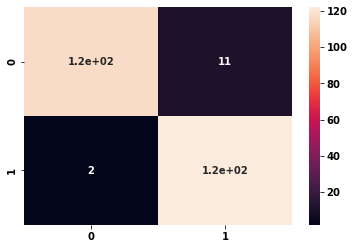

In [76]:
score = cbc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

**0'ları 0.91'le 1'leri 0.98'le biliyor, testte en iyi sonuçları CatBoost vermiş oldu böylelikle, oldukça başarılı** 

### CatBoost çok iyi gözüküyor, Random Forest ve Support Vector'ün (rbf ve poly kernellerinde) skorlarından memnunum. Bunlar üstünden çalışacağım.

## Hyperparameter Tuning

In [44]:
# random forest üzerinden hyperparameter tuning yapacağım
# support vector'ü tuning denemem default sonuçları verdiği için o kısmı sonradan sildim 
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [45]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 7)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 8)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 8, 12, 15, 19, 22, 26, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 250, 400, 550, 700, 850, 1000]}


In [46]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 12, 15, 19, 22, 26,
                                                      30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 250, 400, 550,
                                                         700, 850, 1000]},
                   random_state=42, verbose=2)

In [47]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 26,
 'bootstrap': True}

93.65079365079364

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       128
           1       0.99      0.88      0.93       124

    accuracy                           0.94       252
   macro avg       0.94      0.94      0.94       252
weighted avg       0.94      0.94      0.94       252



<AxesSubplot:>

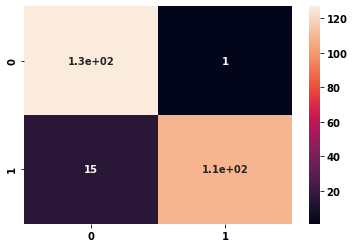

In [48]:
# RandomizedSearchCV'nin bulduğu en iyi parametler uygulanarak 2. RandomForest modelinin oluşturulması
rfc2 = RandomForestClassifier(n_estimators=100,min_samples_split=2,min_samples_leaf=1,max_features='sqrt'
                            ,max_depth=26,bootstrap='False', random_state=42)
rfc2.fit(X_train, y_train)

preds = rfc2.predict(X_test)

score = rfc2.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

**Tuning sonrası 0'ların tahmin başarısı 0.03 artararak 0.99'a gelirken 1'lerde 0.01 puanlık bir düşüş oldu, o yüzden validationda hem tuningli hem tuningsiz hallerini denemeye karar verdim** 

## Validation Encoding

In [49]:
# önce ordinal encoder'i belirttiğim kolonlara uyguluyorum

df2_val = df1_val
oe = OrdinalEncoder(categories=[educ,sever,age,months,premium,deduct], dtype = "int64")
df2_val[ordinal_list] = oe.fit_transform(df2_val[ordinal_list])
df2_val[ordinal_list].head()

,insured_education_level,incident_severity,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
752,4,1,0,8,1,0
74,1,1,5,4,2,1
914,4,2,5,2,1,2
883,1,2,4,2,2,1
839,1,2,6,4,2,0


In [50]:
# fit edilmiş ohe ve column transformer üstünden oluşturdum 
# bu sayede aynı sayıda kolon oluştu (fit edilmiş ohe'deki handle_unknown=ignore sayesinde)
df2_val = pd.DataFrame(ct.transform(df2_val).toarray(), columns=ct.get_feature_names())

In [51]:
df2_val.head()

,onehotencoder__x0_FEMALE,onehotencoder__x0_MALE,onehotencoder__x1_IL,onehotencoder__x1_IN,onehotencoder__x1_OH,onehotencoder__x2_0.0,onehotencoder__x2_9999,onehotencoder__x2_other,onehotencoder__x3_adm-clerical,onehotencoder__x3_armed-forces,...,bodily_injuries,witnesses,total_claim_amount,auto_year,claim_day_of_policy,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group,fraud_reported
0,0,1,1,0,0,1,0,0,0,0,...,0,2,38640,1997,5718,0,8,1,0,0
1,1,0,1,0,0,1,0,0,0,0,...,1,0,42930,2005,3972,5,4,2,1,0
2,1,0,0,0,1,1,0,0,0,0,...,0,2,72800,1998,5343,5,2,1,2,0
3,1,0,0,0,1,1,0,0,0,0,...,0,3,34160,2005,3374,4,2,2,1,1
4,0,1,0,0,1,1,0,0,0,0,...,2,2,51600,2011,9106,6,4,2,0,0


## Validation Feature and Target

In [52]:
X_val = df2_val.loc[:, df2_val.columns != 'fraud_reported']
y_val = df2_val["fraud_reported"]

## Validation Scaling

In [53]:
sc = StandardScaler()
X_val = sc.fit_transform(X_val)

In [54]:
X_val

array([[-1.0944415 ,  1.0944415 ,  1.54590766, ...,  1.77740273,
        -1.86988495, -1.15579349],
       [ 0.91370804, -0.91370804,  1.54590766, ...,  0.1045531 ,
         0.05783149,  0.10050378],
       [ 0.91370804, -0.91370804, -0.64686916, ..., -0.73187171,
        -1.86988495,  1.35680105],
       ...,
       [-1.0944415 ,  1.0944415 , -0.64686916, ...,  0.94097792,
         0.05783149, -1.15579349],
       [-1.0944415 ,  1.0944415 , -0.64686916, ...,  1.35919032,
         0.05783149,  1.35680105],
       [ 0.91370804, -0.91370804, -0.64686916, ...,  1.35919032,
         0.05783149,  0.10050378]])

## Modellerin Validationda Denenmesi

### Tuningli RandomForest

53.0

              precision    recall  f1-score   support

           0       0.92      0.47      0.62       163
           1       0.26      0.81      0.39        37

    accuracy                           0.53       200
   macro avg       0.59      0.64      0.50       200
weighted avg       0.79      0.53      0.58       200



<AxesSubplot:>

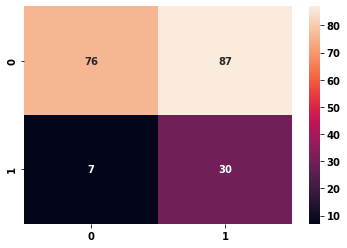

In [55]:
preds = rfc2.predict(X_val)
score = rfc2.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

**1'lerin tahmin başarısı fena değilken 0'larda düşük kaldı, thresholdla oynayarak bu durumu düzeltmeye çalışacağım**

In [56]:
# 1 tahmininin thresholdunu 0.58'e yükselttim
preds = (rfc2.predict_proba(X_val)[:,1] >= 0.58).astype(bool)
print()
print(classification_report(y_val, preds))


              precision    recall  f1-score   support

           0       0.90      0.68      0.78       163
           1       0.32      0.68      0.44        37

    accuracy                           0.68       200
   macro avg       0.61      0.68      0.61       200
weighted avg       0.80      0.68      0.71       200



**Yeni threshold değeriyle 68'e 68 olarak modeli dengeledim. Validationda en iyi çalışan model bu oldu**

### Tuningsiz RandomForest

40.0

              precision    recall  f1-score   support

           0       0.92      0.29      0.44       163
           1       0.22      0.89      0.35        37

    accuracy                           0.40       200
   macro avg       0.57      0.59      0.40       200
weighted avg       0.79      0.40      0.42       200



<AxesSubplot:>

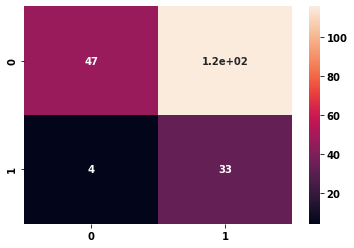

In [57]:
preds = rfc.predict(X_val)
score = rfc.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

**Tuningsiz haline göre 0'ların tahmini çok daha kötü, 1'lerin tahmini biraz daha iyi. 0-1 arasındaki makas çok açık olduğundan burada da threshold değiştirmeyi deneyeceğim**

In [58]:
# 1 tahminin thresholdunu 0.6'ya yükselttim
preds = (rfc.predict_proba(X_val)[:,1] >= 0.6).astype(bool)
print()
print(classification_report(y_val, preds))


              precision    recall  f1-score   support

           0       0.89      0.64      0.75       163
           1       0.29      0.65      0.40        37

    accuracy                           0.65       200
   macro avg       0.59      0.65      0.58       200
weighted avg       0.78      0.65      0.68       200



**1 ve 0'ı dengelemeye çalışınca Tuningli RandomForest'a oranla az bir düşüş oldu**

### SupportVector

74.0
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       163
           1       0.24      0.19      0.21        37

    accuracy                           0.74       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.72      0.74      0.73       200



<AxesSubplot:>

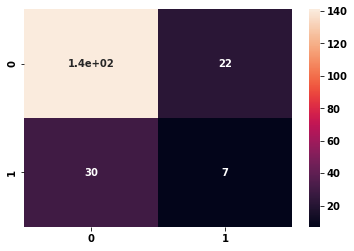

In [59]:
preds = svc.predict(X_val)

score = svc.score(X_val, y_val)
print(score*100)
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

**0'ların tahmini çok başarılıyken 1'lerin tahmini son derece başarısız**

75.5
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       163
           1       0.32      0.30      0.31        37

    accuracy                           0.76       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.75      0.76      0.75       200



<AxesSubplot:>

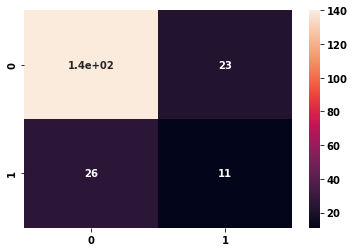

In [60]:
preds = svc_rbf.predict(X_val)

score = svc_rbf.score(X_val, y_val)
print(score*100)
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

**Poly kerneline göre 1'lerin tahmini yaklaşık 2 kat daha başarılı, bunda da threshold değiştirerek 1 ve 0 tahminini dengelemeye çalışacağım**

In [61]:
# 1'lerin tahmin thresholdunu 0.25'e düşürdüm
preds = (svc_rbf.predict_proba(X_val)[:,1] >= 0.25).astype(bool)

print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.86      0.63      0.73       163
           1       0.26      0.57      0.35        37

    accuracy                           0.61       200
   macro avg       0.56      0.60      0.54       200
weighted avg       0.75      0.62      0.66       200



**Threshold ayarlamasından sonra RandomForest kadar başarı olamadığı gözüktü**

### CatBoost

77.5
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       163
           1       0.44      0.81      0.57        37

    accuracy                           0.78       200
   macro avg       0.69      0.79      0.71       200
weighted avg       0.85      0.78      0.80       200



<AxesSubplot:>

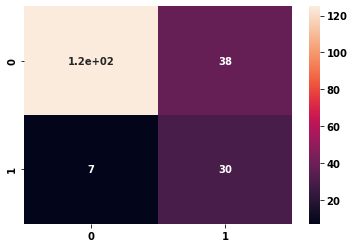

In [70]:
preds = cbc.predict(X_val)

score = cbc.score(X_val, y_val)
print(score*100)
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

**CatBoost en başarılı tahmini yaptı. 1'leri 0.81'le 0'ları 0.77 ile bilmesi diğer modellere göre oldukça başarılı olduğunu gösteriyor**

### VotingClassiferla Model Birleştirme

**RandomForest**'ın 1'lerde **SupportVector**'un 0'larda çok daha başarılı olmasından dolayı, bunları birlikte çalıştırıp çalıştıramayacağımı düşündüm. VotingClassifer'la bunu yapabileceğimi öğrenip ardından uygulamayı denedim

In [65]:
from sklearn.ensemble import VotingClassifier

#voting soft sayesinde predict_probası daha yüksek olanın tahmininin geçerli olmasını sağladım
eclf1 = VotingClassifier(estimators=[
        ('rfc', rfc2), ('svc', svc_rbf)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train)

preds = eclf1.predict(X_val)

print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       163
           1       0.29      0.38      0.33        37

    accuracy                           0.71       200
   macro avg       0.57      0.58      0.57       200
weighted avg       0.75      0.71      0.73       200



**Görüldüğü gibi pek başarılı sonuçlar vermedi.**

In [63]:
# 2 modelin 0 ve 1 tahmin olasılıkları yan yana görülebilir burada
print(eclf1.transform(X_val))

[[0.95       0.05       0.8592595  0.1407405 ]
 [0.93       0.07       0.85922434 0.14077566]
 [0.82       0.18       0.85924744 0.14075256]
 [0.3        0.7        0.56121939 0.43878061]
 [0.91       0.09       0.85916741 0.14083259]
 [0.17       0.83       0.36428688 0.63571312]
 [0.96       0.04       0.85922374 0.14077626]
 [0.98       0.02       0.87196824 0.12803176]
 [0.38       0.62       0.62733036 0.37266964]
 [0.91       0.09       0.85920502 0.14079498]
 [0.21       0.79       0.39841533 0.60158467]
 [0.97       0.03       0.85913756 0.14086244]
 [0.97       0.03       0.85928457 0.14071543]
 [0.94       0.06       0.85922769 0.14077231]
 [0.91       0.09       0.85919882 0.14080118]
 [0.97       0.03       0.88445755 0.11554245]
 [0.9        0.1        0.85915209 0.14084791]
 [0.97       0.03       0.86062204 0.13937796]
 [0.77       0.23       0.85924172 0.14075828]
 [0.07       0.93       0.4725408  0.5274592 ]
 [0.77       0.23       0.8592515  0.1407485 ]
 [0.82       

In [66]:
# tuningsiz rfc'yle denedim ve orada da yaklaşık aynı değer çıktı
eclf2 = VotingClassifier(estimators=[
        ('rfc', rfc), ('svc', svc_rbf)], voting='soft')
eclf2 = eclf2.fit(X_train, y_train)

preds = eclf2.predict(X_val)

print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       163
           1       0.31      0.41      0.35        37

    accuracy                           0.72       200
   macro avg       0.58      0.60      0.59       200
weighted avg       0.75      0.72      0.73       200



## Sonuç

Validation setinde tek modeller arasında en başarılı dengeli sonucu **CatBoost** verdi, **0.77-0.81 recall** değerleri diğer modellere göre oldukça yüksek. Ondan sonraki en başarılı olan **Tuningli RandomForest** threshold değerleri değiştirildikten sonra **0.68-0.68 recall** değerlerini vermişti ancak CatBoost'la arasında önemli bir fark var. En yüksek 1 doğruluğuna bakarsak da **Tuningsiz RandomForest 0.89**'luk başarısıyla modellerim arasındaki en yüksek değeri elde etti, ancak 0 başarısının çok düşük olmasından dolayı modelin çoğu satıra 1 deme eğiliminde olduğu anlaşılabiliyor.

**RandomForest** ve **SupportVector** birleşmelerinden **VotingClassifier** yardımıyla elde ettiğim modeller ise tahminimin aksine başarısız sonuçlar verdi.